In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


In [2]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, auc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler 

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
import eli5 # Feature importance evaluation


from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
df = pd.read_csv("/Users/malkani/Desktop/hotel_bookings (1).csv")

In [4]:

df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [5]:
df.shape

(119390, 32)

In [6]:
print("No. of NA in each columns:", df.isnull().sum(), sep='\n')

No. of NA in each columns:
hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                         

In [7]:
data=df.copy()


# Preprocessing

In [8]:
def perc_mv(x, y):
    perc = y.isnull().sum() / len(x) * 100
    return perc

print('Missing value ratios:\nCompany: {}\nAgent: {}\nCountry: {}'.format(perc_mv(df, df['company']),
                                                                                   perc_mv(df, df['agent']),
                                                                                   perc_mv(df, df['country'])))

Missing value ratios:
Company: 94.30689337465449
Agent: 13.686238378423655
Country: 0.40874445095904177


In [10]:
# company is dropped
data = data.drop(['company'], axis = 1)

In [11]:
# We have also 4 missing values in children column. If there is no information about children, In my opinion those customers do not have any children.
data['children'] = data['children'].fillna(0)

We should check the features to create some more meaningful variables and reduce the number of features if it is possible.

In [12]:
data.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [13]:
# I wanted to label them manually. I will do the rest with get.dummies or label_encoder.
data['hotel'] = data['hotel'].map({'Resort Hotel':0, 'City Hotel':1})

data['arrival_date_month'] = data['arrival_date_month'].map({'January':1, 'February': 2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7,
                                                            'August':8, 'September':9, 'October':10, 'November':11, 'December':12})

In [14]:
def family(data):
    if ((data['adults'] > 0) & (data['children'] > 0)):
        val = 1
    elif ((data['adults'] > 0) & (data['babies'] > 0)):
        val = 1
    else:
        val = 0
    return val

def deposit(data):
    if ((data['deposit_type'] == 'No Deposit') | (data['deposit_type'] == 'Refundable')):
        return 0
    else:
        return 1

In [15]:
def feature(data):
    data["is_family"] = data.apply(family, axis = 1)
    data["total_customer"] = data["adults"] + data["children"] + data["babies"]
    data["deposit_given"] = data.apply(deposit, axis=1)
    data["total_nights"] = data["stays_in_weekend_nights"]+ data["stays_in_week_nights"]
    return data

data = feature(data)

In [16]:
# Information of these columns is also inside of new features, so it is better to drop them.
# I did not drop stays_nights features, I can't decide which feature is more important there.
data = data.drop(columns = ['adults', 'babies', 'children', 'deposit_type', 'reservation_status_date'])

In [17]:
data.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'is_family', 'total_customer', 'deposit_given',
       'total_nights'],
      dtype='object')

In [18]:
# Lets copy data to check the correlation between variables. 
cor_data = data.copy()

In [19]:
le = LabelEncoder()

In [20]:
# This data will not be used while predicting cancellation. This is just for checking correlation.
cor_data['meal'] = le.fit_transform(cor_data['meal'])
cor_data['distribution_channel'] = le.fit_transform(cor_data['distribution_channel'])
cor_data['reserved_room_type'] = le.fit_transform(cor_data['reserved_room_type'])
cor_data['assigned_room_type'] = le.fit_transform(cor_data['assigned_room_type'])
cor_data['agent'] = le.fit_transform(cor_data['agent'])
cor_data['customer_type'] = le.fit_transform(cor_data['customer_type'])
cor_data['reservation_status'] = le.fit_transform(cor_data['reservation_status'])
cor_data['market_segment'] = le.fit_transform(cor_data['market_segment'])

In [21]:
cor_data.corr()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,meal,...,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,is_family,total_customer,deposit_given,total_nights
hotel,1.000000,0.136531,0.075381,0.035267,0.001817,0.001270,-0.001862,-0.186596,-0.234020,0.008018,...,0.072432,0.047531,0.096719,-0.218873,-0.043390,-0.124331,-0.058306,-0.040821,0.172003,-0.247479
is_canceled,0.136531,1.000000,0.293123,0.016660,0.011022,0.008148,-0.006130,-0.001791,0.024765,-0.017678,...,0.054186,-0.068140,0.047557,-0.195498,-0.234658,-0.917196,-0.013010,0.046522,0.481457,0.017779
lead_time,0.075381,0.293123,1.000000,0.040142,0.131424,0.126871,0.002268,0.085671,0.165799,0.000349,...,0.170084,0.073403,-0.063077,-0.116451,-0.095712,-0.302175,-0.043972,0.072265,0.380179,0.157167
arrival_date_year,0.035267,0.016660,0.040142,1.000000,-0.527739,-0.540561,-0.000221,0.021497,0.030883,0.065840,...,-0.056497,-0.006149,0.197580,-0.013684,0.108531,-0.017683,0.052711,0.052127,-0.065963,0.031438
arrival_date_month,0.001817,0.011022,0.131424,-0.527739,1.000000,0.995105,-0.026063,0.018440,0.019212,-0.015205,...,0.019045,-0.029753,0.079315,0.000257,0.028026,-0.021090,0.010427,0.027252,0.008746,0.021536
arrival_date_week_number,0.001270,0.008148,0.126871,-0.540561,0.995105,1.000000,0.066809,0.018208,0.015558,-0.017381,...,0.022933,-0.028432,0.075791,0.001920,0.026149,-0.017387,0.010611,0.025220,0.007773,0.018719
arrival_date_day_of_month,-0.001862,-0.006130,0.002268,-0.000221,-0.026063,0.066809,1.000000,-0.016354,-0.028174,-0.007086,...,0.022728,0.012188,0.030245,0.008683,0.003062,0.011460,0.014710,0.006742,-0.008616,-0.027408
stays_in_weekend_nights,-0.186596,-0.001791,0.085671,0.021497,0.018440,0.018208,-0.016354,1.000000,0.498969,0.045744,...,-0.054151,-0.109220,0.049342,-0.018554,0.072671,0.008558,0.052306,0.101426,-0.114275,0.762790
stays_in_week_nights,-0.234020,0.024765,0.165799,0.030883,0.019212,0.015558,-0.028174,0.498969,1.000000,0.036742,...,-0.002020,-0.127223,0.065237,-0.024859,0.068192,-0.021607,0.050424,0.101665,-0.079999,0.941005
meal,0.008018,-0.017678,0.000349,0.065840,-0.015205,-0.017381,-0.007086,0.045744,0.036742,1.000000,...,-0.007132,0.044658,0.059098,-0.038923,0.023136,0.015393,-0.041727,-0.005975,-0.090725,0.045277


In [45]:
cor_data.corr()["is_canceled"].sort_values()

reservation_status               -0.917228
total_of_special_requests        -0.235595
required_car_parking_spaces      -0.194801
assigned_room_type               -0.175882
booking_changes                  -0.144669
is_repeated_guest                -0.085185
customer_type                    -0.068698
reserved_room_type               -0.062228
previous_bookings_not_canceled   -0.055495
meal                             -0.018679
is_family                        -0.013271
arrival_date_day_of_month        -0.006173
arrival_date_year                 0.016339
stays_in_week_nights              0.024103
total_customer                    0.045046
adr                               0.046133
days_in_waiting_list              0.054008
market_segment                    0.056972
previous_cancellations            0.109914
hotel                             0.133990
distribution_channel              0.165596
lead_time                         0.291940
deposit_given                     0.481318
is_canceled

In [22]:
cor_data = cor_data.drop(columns = ['total_nights', 'arrival_date_week_number', 'stays_in_weekend_nights', 'arrival_date_month', 'agent'], axis = 1)

In [23]:
#Lets delete the NA rows of country column
indices = cor_data.loc[pd.isna(cor_data["country"]), :].index 
cor_data = cor_data.drop(cor_data.index[indices])   
cor_data.isnull().sum()

#There is no missing value in the data

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_day_of_month         0
stays_in_week_nights              0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
reservation_status                0
is_family                         0
total_customer                    0
deposit_given                     0
dtype: int64

In [24]:
indices = data.loc[pd.isna(data["country"]), :].index 
data = data.drop(data.index[indices])   
data = data.drop(columns = ['arrival_date_week_number', 'stays_in_weekend_nights', 'arrival_date_month', 'agent'], axis = 1)


In [25]:
data.columns


Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_day_of_month', 'stays_in_week_nights', 'meal', 'country',
       'market_segment', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'assigned_room_type', 'booking_changes',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'is_family', 'total_customer', 'deposit_given',
       'total_nights'],
      dtype='object')

In [26]:
# I keep data in case of any changes on features, missing values etc.
df1 = data.copy()

In [27]:
#one-hot-encoding
df1 = pd.get_dummies(data = df1, columns = ['meal', 'market_segment', 'distribution_channel',
                                            'reserved_room_type', 'assigned_room_type', 'customer_type', 'reservation_status'])

In [28]:
df1['country'] = le.fit_transform(df1['country']) 
# There are more than 300 classes, so I wanted to use label encoder on this feature.

# Decision Tree Model 

In [29]:
y = df1["is_canceled"]
X = df1.drop(["is_canceled"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [30]:
cart = DecisionTreeClassifier(max_depth = 12)

In [31]:
cart_model = cart.fit(X_train, y_train)

In [32]:
y_pred = cart_model.predict(X_test)

In [33]:
print('Decision Tree Model')

print('Accuracy Score: {}\n\nConfusion Matrix:\n {}\n\nAUC Score: {}'
      .format(accuracy_score(y_test,y_pred), confusion_matrix(y_test,y_pred), roc_auc_score(y_test,y_pred)))

Decision Tree Model
Accuracy Score: 1.0

Confusion Matrix:
 [[22353     0]
 [    0 13318]]

AUC Score: 1.0


### Final Arrangements Before Comparing the Models

In [34]:
df2 = df1.drop(columns = ['reservation_status_Canceled', 'reservation_status_Check-Out', 'reservation_status_No-Show'], axis = 1)

In [35]:
y = df2["is_canceled"]
X = df2.drop(["is_canceled"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [36]:
def model(algorithm, X_train, X_test, y_train, y_test):
    alg = algorithm
    alg_model = alg.fit(X_train, y_train)
    global y_prob, y_pred
    y_prob = alg.predict_proba(X_test)[:,1]
    y_pred = alg_model.predict(X_test)

    print('Accuracy Score: {}\n\nConfusion Matrix:\n {}'
      .format(accuracy_score(y_test,y_pred), confusion_matrix(y_test,y_pred)))
    

def ROC(y_test, y_prob):
    
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_prob)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    plt.figure(figsize = (10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, color = 'red', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linestyle = '--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

# Logistic Regression Model

In [37]:
print('Model: Logistic Regression\n')
model(LogisticRegression(solver = "liblinear"), X_train, X_test, y_train, y_test)


Model: Logistic Regression

Accuracy Score: 0.8043508732583892

Confusion Matrix:
 [[20495  1858]
 [ 5121  8197]]


# Gaussian Naive Bayes Model

In [38]:
print('Model: Gaussian Naive Bayes\n')
model(GaussianNB(), X_train, X_test, y_train, y_test)

Model: Gaussian Naive Bayes

Accuracy Score: 0.586246530795324

Confusion Matrix:
 [[ 9604 12749]
 [ 2010 11308]]


# Decision Tree Model

In [39]:
# after excluding reservation_status 
print('Model: Decision Tree\n')
model(DecisionTreeClassifier(max_depth = 12), X_train, X_test, y_train, y_test)

Model: Decision Tree

Accuracy Score: 0.8464579069832637

Confusion Matrix:
 [[20378  1975]
 [ 3502  9816]]


# Random Forest

In [40]:
print('Model: Random Forest\n')
model(RandomForestClassifier(), X_train, X_test, y_train, y_test)

Model: Random Forest

Accuracy Score: 0.8719127582630147

Confusion Matrix:
 [[20982  1371]
 [ 3198 10120]]


# Neural Network Model

In [41]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [42]:
print('Model: Neural Network\n')
model(MLPClassifier(), X_train_scaled, X_test_scaled, y_train, y_test)


Model: Neural Network

Accuracy Score: 0.8479717417510022

Confusion Matrix:
 [[19961  2392]
 [ 3031 10287]]


In [44]:
table = pd.DataFrame({"Model": ["Decision Tree (reservation status included)", "Logistic Regression",
                                "Naive Bayes", "Decision Tree", "Random Forest",
                                 "Neural Network"],
                     "Accuracy Scores": ["1", "0.804", "0.586", "0.846",
                                         "0.872", "0.848"]})
                     

table["Model"] = table["Model"].astype("category")
table["Accuracy Scores"] = table["Accuracy Scores"].astype("float32")


pd.pivot_table(table, index = ["Model"]).sort_values(by = 'Accuracy Scores', ascending=False)

,Accuracy Scores
Model,
Decision Tree (reservation status included),1.000
Random Forest,0.872
Neural Network,0.848
Decision Tree,0.846
Logistic Regression,0.804
Naive Bayes,0.586


As we can see from the summary table, the best algorithm is random forest for this data set.
0 values are uncalculated ones.
We do not count decision tree with reservatiton status which is broken. All algorithms would give 100% accuracy scores while reservation status is included.

Text(0.5, 0, 'Feature Importances (%)')

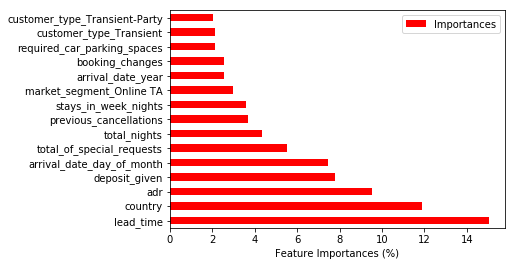

In [46]:
randomf = RandomForestClassifier()
rf_model1 = randomf.fit(X_train, y_train)

pd.DataFrame(data = rf_model1.feature_importances_*100,
                   columns = ["Importances"],
                   index = X_train.columns).sort_values("Importances", ascending = False)[:15].plot(kind = "barh", color = "r")

plt.xlabel("Feature Importances (%)")